In [31]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [32]:
sipp_2018 = pd.read_csv('../data/interim/sipp2018_person/sipp2018_person.csv')
sipp_2018.shape

(49704, 2127)

## Feature Engineering/Transformation

In [3]:
# collapse eeduc categories

m1 = {5:[31,32,33,34,35,36,37,38], 
      6:[39],
      7:[40,41,42],
      8:[45],
      9:[43],
      10:[44,46],
     }
m2 = {v: k for k,vv in m1.items() for v in vv}
m2
sipp_2018['EEDUC_X'] = (sipp_2018
                        .EEDUC
                        .map(m2)
                        .astype('category')
                       )
sipp_2018.EEDUC_X.value_counts()

# create debt to income feature

sipp_2018.loc[sipp_2018.TFTOTINC < 0, 'TFTOTINC'] = 0   # bottom code negative income values

sipp_2018 = (sipp_2018
             .assign(debt_income_ratio = sipp_2018.TDEBT_AST / (sipp_2018.TFTOTINC * 12))
            )
sipp_2018.debt_income_ratio.describe()

# income to category
sipp_2018['income_cut'] = pd.cut(sipp_2018.TFTOTINC, bins=10, labels=np.arange(1,11,1))

In [33]:
# Initialize Independent and Target Features 
y = sipp_2018.EOWN_ST.copy()
X = sipp_2018.drop(['SSUID', 'PNUM', 'EOWN_ST', 'TRACE', 'EEDUC'], axis='columns')

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=23,)
train_survey_weight = X_train.WPFINWGT.copy()
X_train = X_train.drop('WPFINWGT', axis='columns')

# Univariate Selection

## Percent Missing Values
* Drop variables that have a high ratio of missing values.
* Create binary indicators to denote miss (or non-missing) values.
* Review of visualize variables with high ratio of missing values.
***
#### Thresholds
* \> 95% Discard
* 50% - 95% No Imputation
* \< 50% Impute

*Other sources recommend discarding nulls above ~65%*

Missing values may also be converted or imputed, depending on variable. <br>
**Example:** Primary language spoken if respondent doesn't speak English. Na's can be converted to 'Speaks English'.

In [35]:
# Return df with all features with % missing values more than 80%
desc = X_train.describe().T
desc = (desc
        .assign(percent_missing = 1 - (desc['count'] / len(X_train)))
        .percent_missing
        .sort_values(ascending=False)
        .to_frame()
        .query('percent_missing > 0')
       )
desc

,percent_missing
EJB6_PVWKTR7,1.000000
EJB5_RENDB,1.000000
TJB3_WKLY3,1.000000
EJB6_INCPB,1.000000
EJB6_CLWRK,1.000000
...,...
TEHC_REGION,0.001207
EFOOD_MNYN,0.001207
EOTHAS_MNYN,0.001207
ETRANS_MNYN,0.001207


**Drop Features w/ High % Missing Values**

In [7]:
high_nan_features = list(desc.T.columns)

# Transform train set
X_train = X_train.drop(high_nan_features, axis='columns')
print(f'X_train shape: {X_train.shape}')

X_train shape: (39763, 290)


## Variance Threshold

In [8]:
# Initialize estimator and fit to training data ----------
vt = VarianceThreshold(threshold=0)
vt.fit(X_train)
vt_mask = vt.get_support()   # Returns True for columns that are NOT constant

# Print # of constant features
print(f'There are {len(X_train.columns) - sum(vt_mask)} features with 0 variance.')

There are 5 features with 0 variance.


In [9]:
# Normalized data approach
'''normalized_df = X_train / X_train.mean()
vt = VarianceThreshold(threshold=(.8*(1-.8)))
vt.fit(normalized_df)
vt_mask = var_thres.get_support()   # Returns True for columns that are NOT constant

# Print # of constant features
print(f'There are {len(normalized_df.columns) - sum(vt_mask)} features with 0 variance.')

# Transform training df ----------
X_train = X_train.loc[:, vt_mask]
print(f'There are {len(X_train.columns)} features remaining having dropped features with 0 variance.')
'''

"normalized_df = X_train / X_train.mean()\nvt = VarianceThreshold(threshold=(.8*(1-.8)))\nvt.fit(normalized_df)\nvt_mask = var_thres.get_support()   # Returns True for columns that are NOT constant\n\n# Print # of constant features\nprint(f'There are {len(normalized_df.columns) - sum(vt_mask)} features with 0 variance.')\n\n# Transform training df ----------\nX_train = X_train.loc[:, vt_mask]\nprint(f'There are {len(X_train.columns)} features remaining having dropped features with 0 variance.')\n"

**Drop Features Below Variance Threshold**

In [10]:
# Transform train set
X_train = X_train.loc[:, vt_mask]
print(f'X_train shape: {X_train.shape}')

X_train shape: (39763, 285)


# Multivariate Selection

## Pairwise Correlations
* Evaluate correlation between independent variables.
* Variable pairs that meet the threshold condition should be tested for correlation with the target variable, the more highly correlated independent variable of the pair should be kept.

Vishal Patel suggests threshold of .65.<br>
[A Practical Guide to Dimensionality Reduction Techniques](https://www.youtube.com/watch?v=ioXKxulmwVQ)

**This function needs to be refined to return variables pairs so they may be tested with the target variable. Remove duplicate pairs of variables**

In [11]:
def correlation(dataset, threshold):
    '''
    Iterates through variable pairs and returns set of feature names that are over provided threshold.
    '''
    col_corr = set()   # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:  # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]   # getting the name of column
                col_corr.add(colname)
    return col_corr

In [12]:
# Create correlation matrix and plot heatmap
## ----- NOTE: this will not run with too many dimensions. Does not run with sipp2018 ---------
'''
corr_matrix = X_train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()
'''

'\ncorr_matrix = X_train.corr()\nplt.figure(figsize=(12,10))\nsns.heatmap(corr_matrix, annot=True, cmap=plt.cm.CMRmap_r)\nplt.show()\n'

In [13]:
# Run correlation test for features
corr_threshold = 0.95
high_corr_features = correlation(X_train, corr_threshold)
print(f'There are {len(high_corr_features)} pairs of features with a correlation > {corr_threshold}.')

There are 48 pairs of features with a correlation > 0.95.


**Drop Highly Correlated Features**

In [14]:
# Transform train set
X_train = X_train.drop(high_corr_features, axis='columns')
print(f'X_train shape: {X_train.shape}')

X_train shape: (39763, 237)


## Correlation w/the Target
Drop variables that have a very low correlation with the target.<br>
If a variable has a very low correlation w/target it wont be useful for the prediction model.

In [15]:
# Create dataframe with variables and correlation with target 
y_corr = pd.DataFrame(columns=['variable', 'coefficient'])

# Iterate through each column in training set
for col in X_train.columns:
    y_corr.loc[len(y_corr.index)] = [col, abs(y.corr(X_train[col]))]
    
y_corr.sort_values(by='coefficient', ascending=False).head(25)

,variable,coefficient
44,EOWN_MF,0.452637
65,TVAL_STMF,0.343188
43,EOWN_MM,0.336387
97,THVAL_STMF,0.309525
49,EOWN_IRAKEO,0.305594
109,THVAL_RET,0.255799
64,TINC_STMF,0.253046
81,TVAL_RET,0.249591
235,EEDUC_X,0.236743
63,TVAL_BANK,0.236125


Plot the distribution to evaluate a coefficient cutoff for variables to keep or discard.<br>
Consider the elbow in the curve and the number of variables retained.

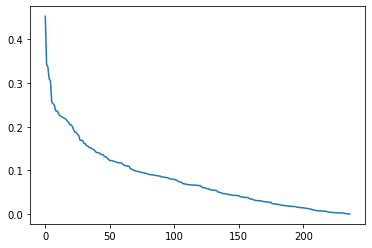

In [16]:
plt.plot(y_corr
         .sort_values(by='coefficient', ascending=False)
         .coefficient
         .to_list()
        );

In [17]:
y_corr[y_corr.coefficient >= .2].sort_values(by='coefficient', ascending=False)
y_corr_features = y_corr[y_corr.coefficient >= .2].variable.to_list()

In [18]:
X_train = X_train.loc[:,y_corr_features]

## Oversample: Synthetic Minority Over-sampling Technique SMOTE

In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy=.67, random_state=23)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print(f'''Shape of X before SMOTE: {X_train.shape}
Shape of X after SMOTE: {X_train_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_train_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (39763, 22)
Shape of X after SMOTE: (58720, 22)

Balance of positive and negative classes (%):


2    59.88079
1    40.11921
Name: EOWN_ST, dtype: float64

In [20]:
# convert cats to cat datatype
cat_cols = ['EOWN_CD', 'EOWN_MM', 'EOWN_MF', 'EOWN_MCBD', 'EOWN_IRAKEO', 'EOWN_ANNTR']
for col in cat_cols:
    X_train_sm[col] = X_train_sm[col].astype('category')
X_train_sm.dtypes

EOWN_CD        category
EOWN_MM        category
EOWN_MF        category
EOWN_MCBD      category
EOWN_IRAKEO    category
EOWN_ANNTR     category
TVAL_BANK         int64
TINC_STMF         int64
TVAL_STMF         int64
TVAL_RET          int64
TVAL_HOME         int64
TEQ_HOME          int64
TVAL_AST          int64
THVAL_BANK        int64
THINC_STMF        int64
THVAL_STMF        int64
THVAL_RET         int64
THVAL_HOME        int64
THEQ_HOME         int64
THVAL_AST         int64
TFCYINCPOV      float64
EEDUC_X        category
dtype: object

## One Hot Encoding

In [21]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
ohe = OneHotEncoder()
ohe.fit(X_train_sm.select_dtypes('category'))
ohe_X = onehot.transform(X_train_sm.select_dtypes('category')).toarray()


In [28]:
ohe.categories_

[array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([1, 2]),
 array([ 5.,  6.,  7.,  8.,  9., 10., nan])]

In [27]:
X_train_sm.select_dtypes('category')

,EOWN_CD,EOWN_MM,EOWN_MF,EOWN_MCBD,EOWN_IRAKEO,EOWN_ANNTR,EEDUC_X
0,2,2,2,2,2,2,10
1,2,2,2,2,2,2,5
2,2,2,2,2,2,2,6
3,2,2,2,2,2,2,6
4,2,2,2,2,2,2,5
...,...,...,...,...,...,...,...
58715,2,1,1,2,1,2,NaN
58716,2,1,1,2,1,2,NaN
58717,1,1,1,2,1,1,NaN
58718,2,1,1,2,2,1,NaN


In [26]:
pd.DataFrame(ohe_X)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58715,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58716,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58717,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58718,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_sm_onehot, y_train_sm)

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)